In [1]:
import torch
import torch.nn as nn
import numpy as np
from torchinterp1d import interp1d


In [4]:
class DownsamplingLayer(nn.Module):
    def __init__(self, padding=5):
        super(DownsamplingLayer, self).__init__()
        self.padding = padding
        self.channels = [
            (4711, 4906, 0.05),
            (5647, 5875, 0.05),
            (6475, 6737, 0.05),
            (7583, 7885, 0.05),
            (15100, 17000, 0.2)
        ]

    def extend_wavelength_grid(self, observed_wavelength):
        extended_wavelengths = []
        for start, end, step in self.channels:
            pre_pad = np.arange(start - self.padding * step, start, step)
            post_pad = np.arange(end + step, end + (self.padding + 1) * step, step)
            channel = np.arange(start, end + step, step)
            extended_wavelengths.extend(pre_pad)
            extended_wavelengths.extend(channel)
            extended_wavelengths.extend(post_pad)
        extended_wavelengths = np.unique(np.array(extended_wavelengths))
        return torch.FloatTensor(extended_wavelengths)

    def forward(self, high_res_flux, high_res_wavelength, observed_wavelengths, device):
        high_res_wavelength = torch.FloatTensor(high_res_wavelength).to(device)
        
        # Ensure high_res_wavelength is sorted
        high_res_wavelength, sorted_indices = high_res_wavelength.sort()
        high_res_flux = high_res_flux[:, sorted_indices]

        # Extend the wavelength grid once for all batches
        extended_wavelength = self.extend_wavelength_grid(observed_wavelengths[0].cpu()).to(device)

        # Perform interpolation for the whole batch
        interpolated_fluxes = []
        for i in range(high_res_flux.size(0)):
            extended_interpolated_flux = interp1d(
                high_res_wavelength.unsqueeze(0),
                high_res_flux[i].unsqueeze(0),
                extended_wavelength.unsqueeze(0)
            )

            observed_interpolated_flux = interp1d(
                high_res_wavelength.unsqueeze(0),
                high_res_flux[i].unsqueeze(0),
                observed_wavelengths[i].unsqueeze(0)
            )

            interpolated_fluxes.append(observed_interpolated_flux.squeeze())

        return torch.stack(interpolated_fluxes)


In [5]:

# Mock data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
high_res_wavelength = np.linspace(4000, 17000, 10000)  # Example high-res wavelengths
batch_size = 2
latent_dim = 100
high_res_flux = torch.randn(batch_size, len(high_res_wavelength)).to(device)
observed_wavelengths = np.array([
    np.linspace(4700, 17000, 500),
    np.linspace(4700, 17000, 500)
])
observed_wavelengths = torch.FloatTensor(observed_wavelengths).to(device)

# Initialize DownsamplingLayer
downsampling_layer = DownsamplingLayer().to(device)

# Debugging run
downsampled_flux = downsampling_layer(high_res_flux, high_res_wavelength, observed_wavelengths, device)
print(downsampled_flux.shape)


torch.Size([2, 500])


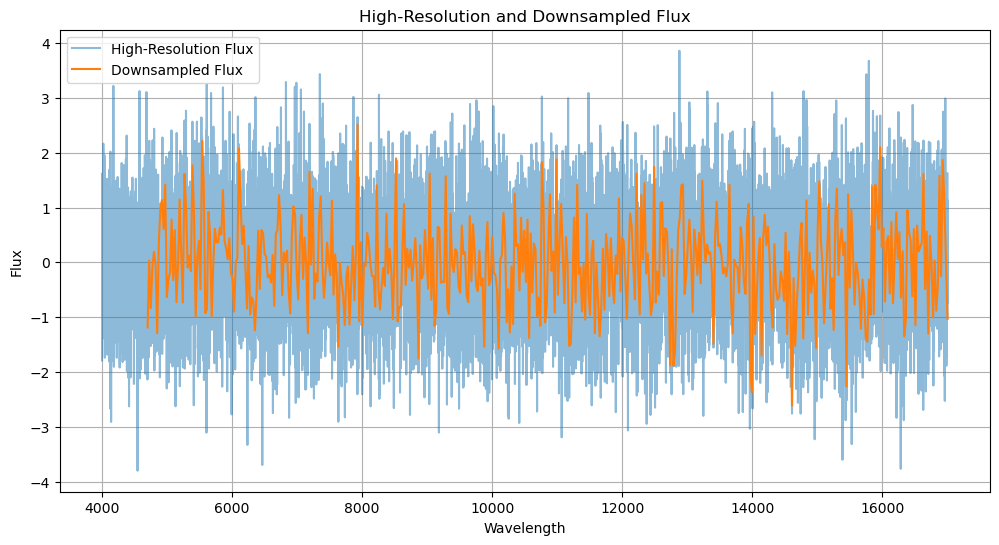

In [7]:
import torch
import torch.nn as nn
import numpy as np
from torchinterp1d import interp1d
import matplotlib.pyplot as plt

class DownsamplingLayer(nn.Module):
    def __init__(self, padding=5):
        super(DownsamplingLayer, self).__init__()
        self.padding = padding
        self.channels = [
            (4711, 4906, 0.05),
            (5647, 5875, 0.05),
            (6475, 6737, 0.05),
            (7583, 7885, 0.05),
            (15100, 17000, 0.2)
        ]

    def extend_wavelength_grid(self, observed_wavelength):
        extended_wavelengths = []
        for start, end, step in self.channels:
            pre_pad = np.arange(start - self.padding * step, start, step)
            post_pad = np.arange(end + step, end + (self.padding + 1) * step, step)
            channel = np.arange(start, end + step, step)
            extended_wavelengths.extend(pre_pad)
            extended_wavelengths.extend(channel)
            extended_wavelengths.extend(post_pad)
        extended_wavelengths = np.unique(np.array(extended_wavelengths))
        return torch.FloatTensor(extended_wavelengths)

    def forward(self, high_res_flux, high_res_wavelength, observed_wavelengths, device):
        high_res_wavelength = torch.FloatTensor(high_res_wavelength).to(device)
        
        # Ensure high_res_wavelength is sorted
        high_res_wavelength, sorted_indices = high_res_wavelength.sort()
        high_res_flux = high_res_flux[:, sorted_indices]

        # Extend the wavelength grid once for all batches
        extended_wavelength = self.extend_wavelength_grid(observed_wavelengths[0].cpu()).to(device)

        # Perform interpolation for the whole batch
        interpolated_fluxes = []
        for i in range(high_res_flux.size(0)):
            extended_interpolated_flux = interp1d(
                high_res_wavelength.unsqueeze(0),
                high_res_flux[i].unsqueeze(0),
                extended_wavelength.unsqueeze(0)
            )

            observed_interpolated_flux = interp1d(
                high_res_wavelength.unsqueeze(0),
                high_res_flux[i].unsqueeze(0),
                observed_wavelengths[i].unsqueeze(0)
            )

            interpolated_fluxes.append(observed_interpolated_flux.squeeze())

        return torch.stack(interpolated_fluxes)

# Mock data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
high_res_wavelength = np.linspace(4000, 17000, 10000)  # Example high-res wavelengths
batch_size = 2
latent_dim = 100
high_res_flux = torch.randn(batch_size, len(high_res_wavelength)).to(device)
observed_wavelengths = np.array([
    np.linspace(4700, 17000, 500),
    np.linspace(4700, 17000, 500)
])
observed_wavelengths = torch.FloatTensor(observed_wavelengths).to(device)

# Initialize DownsamplingLayer
downsampling_layer = DownsamplingLayer().to(device)

# Debugging run
downsampled_flux = downsampling_layer(high_res_flux, high_res_wavelength, observed_wavelengths, device)

# Plotting
plt.figure(figsize=(12, 6))

# Plot high-resolution flux
plt.plot(high_res_wavelength, high_res_flux[0].cpu().numpy(), label='High-Resolution Flux', alpha=0.5)

# Plot downsampled flux
plt.plot(observed_wavelengths[0].cpu().numpy(), downsampled_flux[0].cpu().detach().numpy(), label='Downsampled Flux')
plt.plot(observed_wavelengths[0].cpu().numpy(), downsampled_flux[0].cpu().detach().numpy(), label='Downsampled Flux')

plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.title('High-Resolution and Downsampled Flux')
plt.legend()
plt.grid(True)
plt.show()
